# Sexism Data Collection and Preprocessing

**Authors:** Álvaro D. Gómez Antón, Sabah Serhir Serhir, Elisa M. Ramos Monsoriu, Lautaro Paniati Altamirano, Estefania Solís Valverde, Alba Valverde Porcar

<br></br>

<div style="text-align: right"><i>Explaining Online Sexism: Language Models and a Mexican Perspective</i></div>
    
<div style="text-align: right">A Capstone Project by United Nations International Computing Centre (<a href="https://www.unicc.org/">UNICC</a>) and Universitat Politècnica de València (<a href="https://www.upv.es/es">UPV</a>) </div>

---

In any Data Science project, the first step is to obtain a dataset to work with. In the case of VAWG, data has been collected from various sources to acquire a considerable number of texts labeled as either sexist or non-sexist.

This Notebook outlines the processes that were followed to obtain the final dataset and presents the implemented functions that will be included in the `utils.data` module. Data preprocessing in this case consists of three phases:

1. **Source Integration**: involves the homogenization and merging of all collected datasets to create a unified dataset.
1. **Text Cleaning**: involves the removal of all characters that could negatively affect the model.
1. **Specific Translation**: involves translating data from another language to Spanish. In our case, the data has been translated into Mexican Spanish using GPT-3.5 since the project focuses on Mexico. This decision was made because GPT-3.5 has the ability to adjust the text to sound more like Mexican Spanish, including more culturally specific expressions. Other translation tools such as DeepTL or Google Translate were not chosen because they do not have the same level of customization as GPT-3.5.

**Requiered libraries**

In [64]:
# to handle text
import re  # regexs
import emoji  # emojis 
import string  # punctuation
import unidecode  # accents

# to manage data
import collections  # additional data structures
import pandas as pd  # efficient tabular data 
import numpy as np  # efficient arrays

# to translate text
import openai
import tiktoken

# misc
import os
import time
import datetime as dt
import scipy.stats as st
from copy import deepcopy  # for copying deep dictionaries

# support for type hints
from typing import List, Dict, Tuple, Iterator, Union, Any, Optional 

**Some Helper functions**

In [9]:
def prettytime(t: int):
    """
    Converts a given time in seconds to hh:mm:ss format.
    
    Args:
        t (int): Time in seconds.
    
    Returns:
        str: Time in hh:mm:ss format.
    """
    hh, mm = divmod(t, 3600)
    mm, ss = divmod(mm, 60)
    hh, mm, ss = map(lambda x: str(int(x)), [hh, mm, ss])
    return f'{hh.zfill(2)}:{mm.zfill(2)}:{ss.zfill(2)}'

def timeinfo(func):
    """
    Decorator that calculates the execution time of a function.
    
    Args:
        func (function): Function to be decorated.
    
    Returns:
        function: Decorated function.
    """
    def timecalculator(*args, **kwargs):
        t0 = time.time()
        ans = func(*args, **kwargs)
        t1 = time.time() 
        print(f'\nAll work done in {prettytime(t1-t0)} ({round(t1-t0, 3)}s) :)')
        return ans
    return timecalculator

## Data Sources

In [3]:
def print_data_source(df, dname, sexist_col, type_col=None):
    print(f"Dataset: {dname}")
    print(f"Shape: {df.shape}")
    # show the columns
    cols = df.columns
    print(f"Columns: {list(cols)}")
    # show the labels of the sexism column
    sexist = df[sexist_col].unique()
    print(f"Sexism column values: {sexist}")
    # show the values of sexism type (if present else warn about it)
    if type_col:
        types = df[type_col].unique()
        print(f"Sexism type values: {types}")
    else:
        print("No sexism types reported")
        
d = pd.read_csv("../data/original/edos/edos_labelled_aggregated.csv")        
print_data_source(d, "edos", "label_sexist", "label_category")

Dataset: edos
Shape: (20000, 6)
Columns: ['rewire_id', 'text', 'label_sexist', 'label_category', 'label_vector', 'split']
Sexism column values: ['not sexist' 'sexist']
Sexism type values: ['none' '3. animosity' '2. derogation' '4. prejudiced discussions'
 '1. threats, plans to harm and incitement']


## Source Integration

The first step is to merge all the datasets into one while taking into account the structural differences between them. For example, not all datasets have the same variable names, some have more variables, and others may lack variables that are of interest to us. It can be quite a mess.

To carry out this integration, two functions have been defined:

- `homogenize`: This function is used to convert a dataset's specific format (column names, variables, etc.) to a "common" format (same number of columns, order, names, etc.) so that they can be easily integrated by concatenating them.

- `integrate`: This function concatenates the data and has been implemented to work with an "integration schema." This schema allows for the reading, homogenization, and integration of all sources at once without having to call the functions manually for each dataset.

In [29]:
label2int = lambda x, positive: 1 if x == positive else 0
int2label = lambda x, positive, negative: positive if x else negative


def homogenize(
    
        *datasets: List[pd.DataFrame],
        common_columns = list,
        column_mapping: Dict[Union[str, None], Union[str, list]] = {},
        label_positive: Optional[Union[bool, str]] = None,
        target_column: Optional[str] = None,
        constant_columns: Optional[Tuple[str, str]] = None,
    
    ) -> pd.DataFrame:
    """
    Homogenize the format of multiple data sources into a common format.

    PARAMETERS: 
        - datasets: A list of DataFrame objects to homogenize (expecting 
            the same format across datasets). The starred expression 
            allows passing multiple pandas.DataFrame objects directly.
        - common_columns: A list of column names that should be present in the 
            final homogenized data.
        - column_mapping: A dictionary specifying how to map actual column 
            names to the required common column names if they are different.
        - label_positive: The positive label to consider when converting the 
            target column to an integer (if needed).
        - target_column: The name of the target column to be converted to an 
            integer (if needed).
        - constant_columns: A tuple specifying source-specific constant 
            columns to be added to the homogenized DataFrame. It should contain 
            pairs of column names and their corresponding constant values.
    
    RETURNS: The homogenized data as a pandas DataFrame with the specified 
        common columns.
    """

    if len(datasets) == 1:
        aux = datasets[0].copy()
    else: 
        aux = pd.concat(datasets, ignore_index=True)

    # some relevant variables
    len_df = len(aux)

    # renaming columns to common names
    aux = aux.rename(columns=column_mapping) 

    # astype target column to int if needed
    if label_positive:

        # if its boolean, astyping directly more efficient
        if isinstance(label_positive, bool): 
            aux[target_column] = aux[target_column].astype(int)

        # if its string, conventional label to int
        elif isinstance(label_positive, str): 
            aux[target_column] = aux[target_column].apply(label2int, positive=label_positive)

    # add source specific constant columns        
    for colname, value in constant_columns:
        aux[colname] = [value] * len_df

    # select common columns
    aux = aux.loc[:, common_columns]

    return aux


def homogenize_column(df: pd.DataFrame, column: str, values_mapping: dict):
    df = df.copy()
    for new, actual in values_mapping.items():
        df[column] = df[column].apply(lambda x: new if x in actual else x)
    return df


def print_integration_schema_template():
    print("""
    schema = {
     <data_source1_folder_name_in_original_data_path>: {
         "read": {
             "files" : [
                 <relative_filename1>,
                 <relative_filename2>,
                 ...
             ],
             "kwargs": {
                 <pandas_read_csv_kwarg1>: value_kwarg1,
                 <pandas_read_csv_kwarg2>: value_kwarg2,
                 ...
             } (if needed)                   
         },
         "homogenize": {
             "column_mapping": {
                 <actual_column_name1_in_data_source>: <required_common_column_name1>, (if different)
                 <actual_column_name2_in_data_source>: <required_common_column_name2>, (if different)
                 ... 
             },
             "label_positive": value (if needed)
             "constant_columns": [
                 (<required_common_column1_not_in_source>, None),
                 (<required_common_column2_not_in_source>, None),
                 ...
                 (<col_name1>, <const_value1>), 
                 (<col_name2>, <const_value2>), 
                 ...
             ]
         }
     },
     <data_source2_folder_name_in_original_data_path>: {
         ...
     }
    }
    """)
    
    
IntegrationSchemaType = Dict[str, Dict[str, Dict[str, Union[str, bool, List[str], Dict[str, str]]]]]
@timeinfo
def integrate(
    
    schema: IntegrationSchemaType,
    target_col: str,
    common_columns: List[str],
    extras: Optional[List[Tuple[Callable, str]]] = None,
    original_data_path: Optional[str] = ".",
    save: bool = False,
    save_data_path: Optional[str] = "."
    
) -> pd.DataFrame:
    """
    Homogenize and integrate all the data sources specified in the integration 
    schema.

    PARAMETERS:
        - schema: Integration schema specifying the data sources and their 
            corresponding parameters. Further explained below.
        - target_col: Name of the target column for the integrated data.
        - common_columns: List of common columns across all data sources.
        - extras: Optional list of additional functions to apply on the 
            integrated data. Callables must take as first positional input
            a pandas.DataFrame and must return another one. 
        - original_data_path: Optional path to the original data folder.
        - save: Flag indicating whether to save the integrated data.
        - save_data_path: Optional path to save the integrated data.

    RETURNS: Integrated homogenized data.
    
    The integration schema is a dictionary that specifies the
    configuration for integrating multiple data sources. 
    It consists of key-value pairs, where each key represents 
    a data source folder name in the original data path.

    For each data source, the schema contains two sub-dictionaries: 
    "read" and "homogenize". The "read" dictionary specifies the 
    parameters to be used when reading the files within the data 
    source folder using pandas.read_csv. It includes a "files" key, 
    which holds a list of relative filenames to be read. 
    Additionally, it may contain a "kwargs" key that allows for 
    specifying additional keyword arguments required for reading the files.

    The "homogenize" dictionary corresponds to the keyword arguments 
    used for the data homogenization process. It includes a "column_mapping" 
    key, which maps the actual column names in the data source to the 
    required common column names for integration. If any column names differ 
    between the data source and the common columns, they should be specified 
    in the mapping.

    If necessary, the "homogenize" dictionary can also include a 
    "label_positive" key, which defines the positive label value for the 
    target column. Moreover, there is a "constant_columns" key, which is 
    a list of tuples specifying the required common columns that are not 
    present in the data source. These tuples consist of the column name and 
    either None or a constant value for that column.

    To create an integration schema template, you can use the 
    print_integration_schema_template() function, which prints a sample 
    schema structure. You can replace the 
    <data_source1_folder_name_in_original_data_path> with the actual 
    folder name and follow the same structure for other data sources 
    in the schema.
    
    """
    buffer = []  # Buffer to store data sources homogenized

    for dataset_name_, kwargs in schema.items():
        # Prevent different naming for multilingual cases
        folder_name = dataset_name_.split("_")[0]  
        folder_path = f"{original_data_path}/{folder_name}/"

        # Read data files contained in each data source
        kwargs_read = kwargs["read"].get("kwargs", {})
        datasets = [ pd.read_csv(folder_path + file, **kwargs_read) 
                     for file in kwargs["read"]["files"] ]

        # Homogenize data source
        if "constant_columns" in kwargs['homogenize']:
            kwargs['homogenize']["constant_columns"].append(("dataset", folder_name))
        else:
            kwargs['homogenize']["constant_columns"] = [("dataset", folder_name)]

        homogenized = homogenize(*datasets,
                                 **kwargs['homogenize'],
                                 common_columns=common_columns,
                                 target_column=target_col)

        buffer.append(homogenized)

    # Concatenate all homogenized data sources stored in the buffer
    integrated = pd.concat(buffer, axis=0).reset_index(drop=True)

    # Apply additional functions on the integrated data
    if extras:
        for func, kwargs in extras:
            integrated = func(integrated, **kwargs)

    # Save results if specified
    if save:
        path = f"{save_data_path}/integrated_data.csv"
        integrated.to_csv(path, sep=";")
        print(f"Data correctly integrated and saved in \033[1m'{path}'\033[0m")

    return integrated


**Custom Specification**

The next step is to define the variables required for reading and saving the data:

In [5]:
# contiene las carpetas de cada fuente de datos con sus respectivos ficheros
ORIGINAL_DATA_PATH = "../data/original"

# servirá para guardar los nuevos conjuntos de datos derivados de los anteriores
TRANSFORMED_DATA_PATH = "../data/transformed2"

To define the integration schema, all we need to do is follow the template for each data source:

In [30]:
print_integration_schema_template()


    schema = {
     <data_source1_folder_name_in_original_data_path>: {
         "read": {
             "files" : [
                 <relative_filename1>,
                 <relative_filename2>,
                 ...
             ],
             "kwargs": {
                 <pandas_read_csv_kwarg1>: value_kwarg1,
                 <pandas_read_csv_kwarg2>: value_kwarg2,
                 ...
             } (if needed)                   
         },
         "homogenize": {
             "column_mapping": {
                 <actual_column_name1_in_data_source>: <required_common_column_name1>, (if different)
                 <actual_column_name2_in_data_source>: <required_common_column_name2>, (if different)
                 ... 
             },
             "label_positive": value (if needed)
             "constant_columns": [
                 (<required_common_column1_not_in_source>, None),
                 (<required_common_column2_not_in_source>, None),
                 ...
             

In [27]:
INTEGRATION_SCHEMA = {
    
    "callme": {
        "read": {
            "files": [
                "sexism_data.csv"
            ]
        },
        "homogenize": {
            "column_mapping": {
                "id": "original_id",  
            },
            "label_positive": True,
            "constant_columns": [
                ("type", None), 
                ("language", "en")
            ]
        }
    },
    
    "edos": {
        "read": {
            "files": [
                "edos_labelled_aggregated.csv"
            ]
        },
        "homogenize": {
            "column_mapping": {
                "rewire_id": "original_id",
                "label_sexist": "sexist",
                "label_category": "type",
            },
            "label_positive": "sexist",
            "constant_columns": [
                ("language", "en")
            ]
        }
    },
    
    "evalita": {
        "read": {
            "files": [
                "en_training.tsv", 
                "en_testing.tsv"
            ],
            "kwargs": {
                "sep": "\t"
            }
        },
        "homogenize": {
            "column_mapping": {
                "id": "original_id", 
                "misogynous": "sexist",
                "misogyny_category": "type"
            },
            "constant_columns": [
                ("language", "en")
            ]
        }
    },
    
    "exist": {
        "read": {
            "files": [
                "EXIST2021_training.tsv", 
                "EXIST2021_test_labeled.tsv"
            ],
            "kwargs": {
                "sep": "\t"
            }
        },
        "homogenize": {
            "column_mapping": {
                "id": "original_id", 
                "task1": "sexist",
                "task2": "type",
            },
            "label_positive": "sexist",
        }
    },
    
    "ibereval_en": {
        "read": {
            "files": [
                "en_AMI_TrainingSet_NEW.csv"
            ],
            "kwargs": {
                "sep": ";"
            }
        },
        "homogenize": {
            "column_mapping": {
                "id": "original_id", 
                "tweet": "text", 
                "misogynous": "sexist",
                "misogyny_category": "type"
            },
            "constant_columns": [
                ("language", "en")
            ]
        }
    },
    
    "ibereval_es": {
        "read": {
            "files": [
                "es_AMI_TrainingSet_NEW.csv"
            ],
            "kwargs": {
                "sep": ";"
            }
        },
        "homogenize": {
            "column_mapping": {
                "id": "original_id", 
                "tweet": "text", 
                "misogynous": "sexist",
                "misogyny_category": "type"
            },
            "constant_columns": [
                ("language", "es")
            ]
        }
    },
    
    "metwo": {
        "read": {
            "files": [
                "targetResultFile_full2.csv"
            ],
            "kwargs": {
                "sep": ";", 
                "names": [
                    "original_id", 
                    "text", 
                    "sexist"
                ]
            }
        },
        "homogenize": {
            "label_positive": "SEXIST",
            "constant_columns": [
                ("type", None), 
                ("language", "es")
            ]
        }
    }
}

In [72]:
import json

with open(f"{ORIGINAL_DATA_PATH}/integration_schema.json", "w+", encoding='utf-8') as f:
    json.dump(INTEGRATION_SCHEMA, f, indent=4, ensure_ascii=True)

With the integration schema properly defined, all that's left is to call the `integrate` method.

In [23]:
homogenize_col_kwargs = {
    "column": "type", 
    "values_mapping": {
        "abuse": ['dominance', 'stereotyping-dominance', 'derailing'],
        'hate': ['2. derogation', '3. animosity', '4. prejudiced discussions', 'ideological-inequality'],
        'profanities': ['stereotype', 'misogyny-non-sexual-violence', 'discredit'],
        'violent': ['misogyny-non-sexual-violence', '1. threats, plans to harm and incitement', 'sexual-violence'],
        'sexually-explicit': ['sexual_harassment', 'objectification'],
        'non-sexist': [None, 'none', '0', 'NaN', np.nan]
    }
}
integrated_data = integrate(INTEGRATION_SCHEMA,
                            target_col="sexist",
                            common_columns=["original_id", "text", "sexist", "type", "language", "dataset"],
                            extras=[(homogenize_column, homogenize_col_kwargs)],
                            original_data_path=ORIGINAL_DATA_PATH, 
                            save=True, 
                            save_data_path=TRANSFORMED_DATA_PATH)
integrated_data

Data correctly integrated and saved in '../data/transformed/integrated_data.csv'

All work done in 00:00:02 (2.008s) :)


,original_id,text,sexist,type,language,dataset
0,0,MENTION3481 i didn't even know random was an o...,0,non-sexist,en,callme
1,1,Bottom two should've gone! #mkr,0,non-sexist,en,callme
2,2,MENTION3111 MENTION3424 ladyboner deserves so ...,0,non-sexist,en,callme
3,3,She shall now be known as Sourpuss #MKR #KatAn...,0,non-sexist,en,callme
4,4,Tarah W threw a bunch of women under the bus s...,0,non-sexist,en,callme
...,...,...,...,...,...,...
59000,1047687262455177217,"Yo no puedo darte luz todos los días, pero si ...",0,non-sexist,es,metwo
59001,1064482731739045888,Que bien! Aunque digan que las mujeres no debe...,0,non-sexist,es,metwo
59002,1040584804536856577,@AriOrsingher Y misoginia las pelotas no quier...,0,non-sexist,es,metwo
59003,1051458429280235520,"""Imaginen el tipo de sociedad mojigata y castr...",0,non-sexist,es,metwo


In [11]:
print_data_source(integrated_data, "integrated", "sexist", "type")

Dataset: integrated
Shape: (59005, 6)
Columns: ['original_id', 'text', 'sexist', 'type', 'language', 'dataset']
Sexism column values: [0 1]
Sexism type values: ['non-sexist' 'hate' 'violent' 'abuse' 'sexually-explicit' 'profanities']


And some relevant proportions and counts...

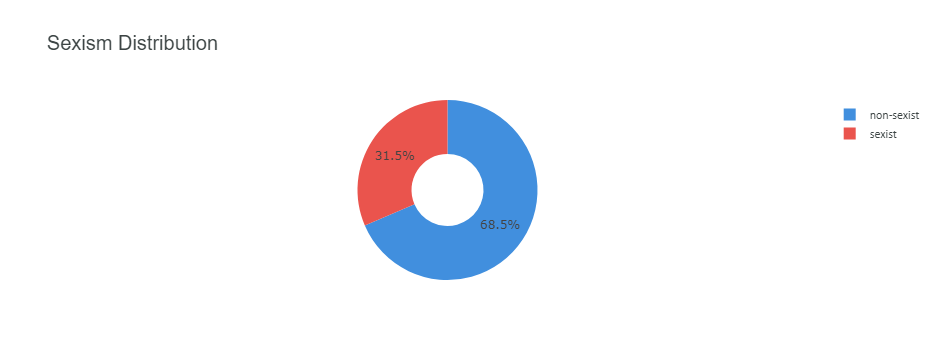

In [39]:
import plotly.express as px
#import matplotlib.pyplot as plt
from collections import Counter
import plotly.graph_objects as go
import numpy as np
import pytz
import ipywidgets as widgets

RED = "#ea544d"
BLUE = "#418fde"
YELL = "#fbd305"
PURP = "#cc64bc"
BLCK = "#3c4444"
GREY = "#f5f5f5"
font = "Calibri"
GREEN="#C4D454"
GREY2='#A08C88'
SALM = '#EB8B59'
BRW='#ECD3BC'
BLUE2='#5BC3E3'

def create_donut_chart(data,
                       colors,
                       labels=None,
                       legend_font='Arial', 
                       legend_color='black', 
                       label_font='Arial', 
                       title_size=20, 
                       title_font='Arial', 
                       title_color='black',
                       background_color='white'):
    #labels = ['non-sexist', 'sexist']
    values = data.value_counts(normalize=True) * 100
    if not labels:
        labels = values.index.tolist()
    fig = go.Figure(data=go.Pie(labels=labels, values=values, hole=0.4, textposition='inside'))
    
    fig.update_traces(marker=dict(colors=colors))
    fig.update_layout(
        title='Sexism Distribution',
        title_font=dict(size=title_size, family=title_font, color=title_color),
        plot_bgcolor=background_color,
        legend=dict(
            font=dict(family=legend_font, color=legend_color),
        )
    )
    return fig
    

colors = [BLUE, RED]  
fig1 = create_donut_chart(integrated_data.sexist, labels=['non-sexist', 'sexist'], colors=colors, 
                   legend_font=font, legend_color=BLCK, label_font=font, title_color=BLCK)
fig1.show()

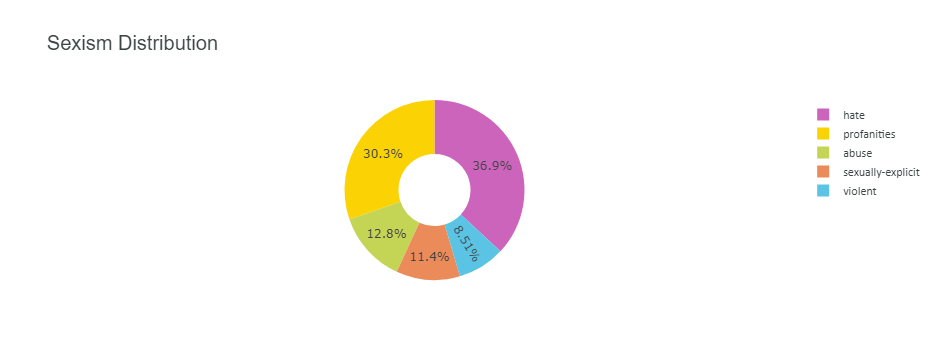

In [40]:
colors = [PURP, YELL, GREEN, SALM, BLUE2] 
fig2 = create_donut_chart(integrated_data.query("type!='non-sexist'").type, colors=colors, 
                   legend_font=font, legend_color=BLCK, label_font=font, title_color=BLCK)
fig2.show()

In [13]:
count = (integrated_data.language == "en").sum()
print(f"English: {round(count/total*100, 2)}%\nSpanish: {round((total-count)/total*100, 2)}%")

English: 80.55%
Spanish: 19.45%


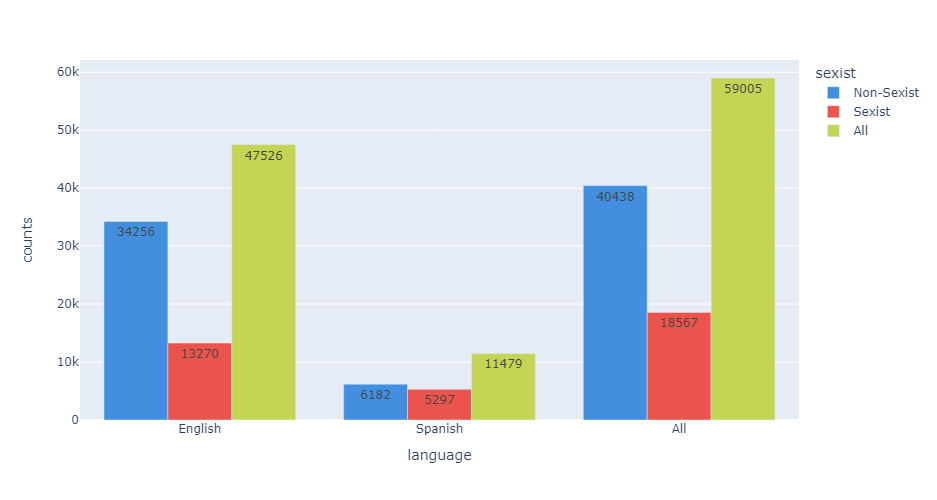

In [98]:
import plotly.express as px

ctb_molten = pd.crosstab(
    integrated_data.sexist.apply(int2label, positive="Sexist", negative="Non-Sexist"),
    integrated_data.language.apply(lambda x: "English" if x == "en" else "Spanish"),
    margins = True
).melt(ignore_index=False, value_name="counts").reset_index()

fig = px.bar(
    ctb_molten,          
    x='language', 
    y='counts', 
    barmode="group", 
    color='sexist', 
    text_auto='i',
    color_discrete_sequence=[BLUE, RED, GREEN],
)

fig.update_layout(
    autosize=True,
    height=500
)
fig.show()

## Text Cleaning

Next step in our pre-process is cleaning text properly. For this task function `clean` is defined, which handles case, blanks, numbers, links, mentions, hashtags, emojis, accents, symbols and punctuation. It allows customizing links, mentions, hashtag and emojis handling and adding custom regexs and its substitution in cleaned text.

In [47]:
def clean(
    
        text: str, 
        keep_case: bool = False,
        keep_accents: bool = False,
        keep_numbers: bool = False,
        lmhe_tokens: Optional[Dict[str, str]] = None, 
        constraints: Optional[List[Tuple[str, str]]] = None,
        allowed_punctuation: Optional[str] = None
    
    ) -> str:
    """
    Clean a given text
    
    PARAMETERS:
        - text: string to clean
        - keep_case: wether to keep original case (True) or not (False). If not text will be lowercased.
        - keep_accents: wether to keep accents (True) or not (False).
        - keep_numbers: wether to keep numbers (True) or not (False).
        - lmhe_tokens: which stands for link-mention-hashtag-emoji_tokens. A dict containing how to represent.
          those items in the final text. If nothing provided (neither dict or specific key), they will be removed.
        - constraints: any special substitution you may want to apply to the text. It must be a list of tuples 
          containing the corresponding regex to capture (first element of the tuple) and the string to substitue 
          it (second element).
        - allowed_punctuation: string containing custom punctuation you may want to avoid cleaning.
        
    RETURNS cleaned text
    """
    
    # lowercase
    if not keep_case:
        text = text.lower() 
    
    #remove \n and \r
    text = text.replace('\r', '').replace('\n', ' ')
    
    if lmhe_tokens is not None:
        # handle links
        text = re.sub(r'(?:www\.|https?://)\S+', lmhe_tokens.get("link", ''), text, flags=re.MULTILINE)  
        
        # handle mentions
        text = re.sub(r'\@\S+', lmhe_tokens.get("mention", ''), text) 
        
        # handle hashtags
        text = re.sub(r'#\S+', lmhe_tokens.get("hashtag", ''), text)
        
        # handle emojis
        text = emoji.replace_emoji(text, lmhe_tokens.get("emoji", ''))  
        
    else:
        # remove links, mentions, hashtags and emojis
        text = re.sub(r'(?:#|\@|www\.|https?://)\S+', '', text, flags=re.MULTILINE) 
        text = emoji.replace_emoji(text, '')
     
    # specific constraints
    if constraints is not None:
        for regex, token in constraints:
            text = re.sub(regex, token, text, flags=re.I)
    
    # remove accents
    if not keep_accents:
        text = unidecode.unidecode(text)  
    
    ## all symbols and punctuation
    banned_list = string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'+'—'  
    ## allowed punctuation
    if allowed_punctuation is not None:  
        banned_list = re.sub(r"[%s]" % re.escape(allowed_punctuation), "", banned_list)
    # remove symbols and punctuation
    text = text.translate(str.maketrans('', '', banned_list)) 
    
    # remove numbers
    if not keep_numbers:
        text = re.sub(r'\d+', '', text)  
    
    # remove extra and leading blanks
    text = re.sub("\s\s+" , " ", text).strip()  
    
    return text

We want to maintain the following punctuation because the models we are going to use had been trained with almost raw text and well know how to interpret them. Also, exclamation and interrogation marks could express some emotions. We maintain inverted commas (') because we don't want cases such "should've" -> "shouldve" on English data. 

In [48]:
ALLOWED_PUNCTUATION = "'\"!¿?.,"

We are going to maintain accents because of the spanish data and because BETO also handles them. Our constraints came from EDOS texts (links as "\[URL\]" and users as "\[USER\]") and CALLME texts (mentions as "MENTION\<number\>" and re-tweets as "RT"), since we want to discard those information.

In [49]:
CONSTRAINTS = [(r"\[URL\]|\[USER\]", ""), (r"MENTION\d+", ""), (r"\bRT\b", "")]

# to maintain twitter features like links or hashtags you should just remove the first constraint
# and uncomment the following variables definition, as the corresponding parameter when calling the function

#CONSTRAINTS = [(r"MENTION\d+", "[USER]"), (r"\bRT\b", "")]
#LMHE_TOKENS = {
#    "link": "[URL]", 
#    "mention": "[USER]", 
#    "hashtag": "[HASHTAG]", 
#    "emoji": "[EMOJI]"
#}
#ALLOWED_PUNCTUATION += "[]"

cleaned_data = integrated_data.copy()
cleaned_data.text = cleaned_data.text.apply(clean, 
                                            keep_case=False,
                                            keep_accents=True,
                                            keep_numbers=True,
                                            constraints=CONSTRAINTS,
                                            #lmhe_tokens=LMHE_TOKENS,
                                            allowed_punctuation=ALLOWED_PUNCTUATION)

#because of the transformations it is posible that some texts get completly empty
cleaned_data = cleaned_data.query("text != ''")
cleaned_data

,original_id,text,sexist,type,language,dataset
0,0,i didn't even know random was an option!,0,non-sexist,en,callme
1,1,bottom two should've gone!,0,non-sexist,en,callme
2,2,ladyboner deserves so much more credit than du...,0,non-sexist,en,callme
3,3,she shall now be known as sourpuss,0,non-sexist,en,callme
4,4,tarah w threw a bunch of women under the bus s...,0,non-sexist,en,callme
...,...,...,...,...,...,...
59000,1047687262455177217,"yo no puedo darte luz todos los días, pero si ...",0,non-sexist,es,metwo
59001,1064482731739045888,que bien! aunque digan que las mujeres no debe...,0,non-sexist,es,metwo
59002,1040584804536856577,y misoginia las pelotas no quiero que vengas a...,0,non-sexist,es,metwo
59003,1051458429280235520,"""imaginen el tipo de sociedad mojigata y castr...",0,non-sexist,es,metwo


In [50]:
cleaned_data.to_csv(f"{TRANSFORMED_DATA_PATH}/cleaned_data.csv", sep=";", index=False)

## Translation

First step is to select English data to be translated.

In [51]:
cleaned_data = pd.read_csv(f"{TRANSFORMED_DATA_PATH}/cleaned_data.csv", sep=";")

In [52]:
cleaned_data_en = cleaned_data.query("language == 'en'")
cleaned_data_en

,original_id,text,sexist,type,language,dataset
0,0,i didn't even know random was an option!,0,non-sexist,en,callme
1,1,bottom two should've gone!,0,non-sexist,en,callme
2,2,ladyboner deserves so much more credit than du...,0,non-sexist,en,callme
3,3,she shall now be known as sourpuss,0,non-sexist,en,callme
4,4,tarah w threw a bunch of women under the bus s...,0,non-sexist,en,callme
...,...,...,...,...,...,...
52996,3230,when someone announces they're unfollowing,0,non-sexist,en,ibereval
52997,3265,when someone announces that they are 'official...,0,non-sexist,en,ibereval
52998,3387,deleted again. working to get it back again,0,non-sexist,en,ibereval
52999,3259,when you're on a first date and she asks to ta...,0,non-sexist,en,ibereval


Let's first look at how many tokens are we going to need and the costs associated.

In [53]:
import tiktoken
import scipy.stats as st 

encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
tokens = np.array([ len(encoding.encode(row.text)) for i, row in cleaned_data_en.iterrows() ])
print(f"Total: {tokens.sum()}\n"
      f"Average: {tokens.mean()}\n"
      f"Median: {np.median(tokens)}\n"
      f"Mode: {st.mode(tokens).mode[0]}\n"
      f"Max: {tokens.max()}\n"
      f"Min: {tokens.min()}\n"
      f"Std: {tokens.std()}")

Total: 1163576
Average: 24.590037828356476
Median: 22.0
Mode: 16
Max: 760
Min: 1
Std: 16.285526457021238


In [54]:
print(f"Price for translating {tokens.sum()} tokens:\n"
      f" {chr(8226)} GPT-3.5 turbo ($0.002/1K): ${round(tokens.sum()*0.002/1000*2, 2)} aprox.\n"
      f" {chr(8226)} GPT-4 ($0.03/1K): ${round(tokens.sum()*0.03/1000*2, 2)} aprox.")

Price for translating 1163576 tokens:
 • GPT-3.5 turbo ($0.002/1K): $4.65 aprox.
 • GPT-4 ($0.03/1K): $69.81 aprox.


### Using GPT

It is important to define some constant variables:

In [62]:
def get_setup_keys(*keys):
    aux, _suggest = {}, False
    for key in keys:
        value = os.getenv(key)
        if value is None:
            value = input(f"Enter your `{key}`: ")
            _suggest = True
        aux[key] = value
    if _suggest:
        print("\nConsider setting keys in system environ to not " \
              "enter them each time setting up is required.")
    return aux

def setup_openai_api():
    import openai
    openai.api_key = get_setup_keys("OPENAI_API_KEY")
    
setup_openai_api()

In [55]:
GPT_MODEL = "gpt-3.5-turbo"
MAX_TOKENS = 4096
RPM = 3  # requests per minute

And to define how our translation process is going to be held. It is important to take into account the extremly large amount of teets we have to translate. Another thing to consider its that making single requests per tweet to the GPT model it worth less, considering that a lot of token can be passed to the API. 

In [60]:
def split_texts_given_max_tokens(
        
        texts: pd.Series, 
        gpt_model: str, 
        max_tokens: int

    ) -> Iterator[Tuple[list, list]]:
    """
    Split long pd.Series of texts into small batches optimized to fit into max_tokens allowed.
    
    Args:
        - texts: (large amount of) indexed tweets to be splitted.
        - gpt_model: GPT model name used for token encoding.
        - max_tokens: maximum number of GPT tokens (computed using tiktoken.encoding_for_model.encode method).
        
    Yield:
        batches of text with their respective indexes (ids).
    """
    
    # Initialize variables
    ids, batch, aux = [], [], 0
    
    # Get encoding for GPT model
    encoding = tiktoken.encoding_for_model(gpt_model)
    
    # Iterate over texts
    for i, txt in texts.items():
        # Get the length of the tweet in tokens
        len_tweet = len(encoding.encode(txt))
        
        # Check if adding the current tweet exceeds the maximum tokens
        if aux + len_tweet < max_tokens:
            # Add tweet and index to the current batch
            batch.append(txt)
            ids.append(i)
            aux += len_tweet
        else:
            # Yield the current batch if the maximum tokens are reached
            yield ids, batch
            
            # Reset batch variables for the next iteration
            ids, batch, aux = [i], [txt], len_tweet
    
    # Yield the last batch if it exists
    if batch:
        yield ids, batch


        
def gpt_translation(texts: list, input_language: str, output_language: str, model: str) -> list:
    """
    Translate text using OpenAI's GPT. 
    
    PARAMETERS:
        - texts: list of raw text to be translated (total tokens contained must not exceed 1500 aprox)
        - input_language: original text language.
        - output_language: language to be translated.
        - model: GPT model name (expected for openai.ChatCompletion.create method)
        
    RETURNS translated texts.
    """
    
    # Set the system message for GPT model
    context = (
        f"Assistant is an intelligent chatbot designed to translate {input_language} tweets into {output_language}.\n" \
        "Instructions:\n" \
        " - You will be provided with one tweet per line. Each line contains tweet's id (first number) and the tweet.\n" \
        " - Ensure that the translations are accurate and preserve the original meaning and tone of each tweet.\n" \
        " - Take into account any slang or informal language used in the tweets, as well as any potential variations in spelling or grammar." \
        " - You must sound as a native speaker when translating tweets."
        " - Each line in your response must correspond to each tweet provided, in the same order and starting with the corresponding tweet's id.\n" \
        " - If you are not able to translate one of them, just omit it"
    )
    
    # Ask GPT for the translation
    return openai.ChatCompletion.create(
        model=model,
        messages=[
            {"role": "system", "content": context},
            {"role": "user", "content": "\n".join(texts)}
        ]
    ).choices[0].message.content.split("\n")


def specific_translation(
        
        texts: pd.Series, 
        original: str, 
        new: str, 
        model_name: str,
        max_tokens: int,
        verbose: bool = False
        
    ) -> Tuple[pd.DataFrame, bool]:
    """
    Translate the pandas Series passed.
    
    Args:
        - texts: indexed tweets to be translated
        - original: data source language
        - new: language to get translations
        - model_name: GPT model name for translation
        - max_tokens: maximum number of tokens allowed for translation
        - verbose: flag to enable verbose output
        
    Returns: 
        pandas.DataFrame: translated text (maintaining tweets' original associated indexes) and a flag indicating success.
    """
    translated, translated_ids, original_ids = [], [], []
    time_buffer, requests_buffer = 0, 0
    
    # Calculate the number of tokens allowed for translation
    allowed_tokens = int((max_tokens-1000)/2)
    
    # For each batch of tweets
    for i, (ids, batch) in enumerate(split_texts_given_max_tokens(texts, model_name, allowed_tokens)):
        t0 = time.time()

        # Transform texts into the form <id_tweet><blank_space><tweet> for a better correspondance with response
        proper_input = pd.Series(ids).astype(str) + " " + pd.Series(batch)
        
        # Ask GPT to translate the texts
        try:
            response = gpt_translation(proper_input, input_language=original, output_language=new, model=model_name)
        except Exception as ex:
            print(f"Oops, there were some issues while translating data: {ex}\n")
            return pd.DataFrame({"original_id": translated_ids, "translated": translated}), False
        
        # Process each translation (response is a list of strings)
        retrieved, correct, incorrect = 0, 0, 0
        for sent in response:
            
            # Normal cases with the same format as the input
            try:
                # Match with the first blank space to split the sentence into id and text
                pos = sent.index(" ")  
                id_ = int(sent[:pos].strip(".").strip(",").strip(":"))  # Get tweet id
                trans = sent[pos+1:]  # Get translated tweet
                correct += 1
            
            # No spaces, just a number; GPT model did not return the sentence translated or the model
            # did not return the id correctly
            except ValueError: 
                continue
            
            # Accumulate ids and text from the response
            translated_ids.append(id_)
            translated.append(trans)
            retrieved += 1
        
        # Accumulate original ids for checking purposes
        original_ids.extend(ids) 

        t1 = time.time()
        
        if verbose:
            print(f"Batch: {i:3} " \
                  f"| Sent: {len(ids)} " \
                  f"| Retrieved: {retrieved}; Translated: {round(correct/retrieved,2)*100}% " \
                  f"| Time: {prettytime(t1-t0)}")
        
        # Control the number of requests to the API
        time_buffer += t1-t0
        requests_buffer += 1
        if requests_buffer == RPM:
            if time_buffer < 60:
                time.sleep(60-time_buffer)
            time_buffer, requests_buffer = 0, 0
            
    return pd.DataFrame({"original_id": translated_ids, "translated": translated}), True

Once we have the functions defined we only have to select our tweets and pass trought `translate`.


> **Note**: At this moment this section of the notebooks is being executed in other machine due to its high amount of time required. It is going to take about 750 batches (between 22 and 55 hours).

In [68]:
@timeinfo
def translate(
    
        texts: Union[list, pd.Series], 
        original: str, 
        new: str, 
        model_settings: dict = {},
        callback: str = "simple", 
        verbose: bool = False,
        tol: int = 10
    
    ) -> pd.DataFrame:
    """
    Translate the given texts.
    
    PARAMETERS:
        - texts: indexed tweets to be translated
        - original: data source language
        - new: language to get translations
        - model_settings: dictionary containing model settings (name and max_tokens)
        - callback: callback type for handling translation failures
        - verbose: flag to enable verbose output
        - tol: tolerance value for remaining untranslated texts in exhaustive mode
        
    RETURNS translated Series (maintaining tweets' original associated indexes)
    """
    if isinstance(texts, list):
        texts = pd.Series(texts)
    
    # Warming up the model
    _ = gpt_translation(texts[:5], original, new, "gpt-3.5-turbo")
    
    if verbose:
        print(f"Starting translation. Callback: {callback}\n")
        
    if callback == "simple":
        # Just calls the default function, without considering connection errors or similar
        translated_text, _ = specific_translation(texts, 
                                                  original=original, 
                                                  new=new, 
                                                  model_name=model_settings.get("name", "gpt-3.5-turbo"),
                                                  max_tokens=model_settings.get("max_tokens", 4096),
                                                  verbose=verbose)

    elif callback == "retrial":
        # Prevents failures due to unexpected errors with the API connection
        translated_text = pd.DataFrame()
        _ok, start = False, texts.index[0]
        while not _ok:
            translated, _ok = specific_translation(texts.loc[start:], 
                                                   original=original, 
                                                   new=new, 
                                                   model_name=model_settings.get("name", "gpt-3.5-turbo"),
                                                   max_tokens=model_settings.get("max_tokens", 4096),
                                                   verbose=verbose)
            translated_text = pd.concat([translated_text, translated], axis=0)
            if _ok:
                break

            print(f"Translation broken at {dt.datetime.now()}")
            start = translated_text.original_id.iloc[-1] + 1
            print(f"Continuing translation phase with text {len(translated_text)+1} out of {len(texts)}.")

            try:
                # Wait for one minute before trying again
                print(f"Waiting one minute before restarting translation. \
                        Press Ctrl+C to stop and get the translated text until now.\n")
                time.sleep(60)
            except KeyboardInterrupt:
                return translated_text
        
    elif callback == "exhaustive":
        # Apart from preventing unexpected errors, calls to translate until 
        # just a constant number (tol) of texts remain untranslated
        translated_text = pd.DataFrame()
        orig_ids = set(texts.index)
        failed = orig_ids - set(translated_text.original_id)
        
        while len(failed) > tol:
            translated = translate(texts.loc[list(failed)], 
                                   original=original, 
                                   new=new, 
                                   call="retrial", 
                                   verbose=verbose)
            # Accumulate translated texts
            translated_text = pd.concat([translated_text, translated], axis=0)
            
            # Check remaining texts to translate
            failed = orig_ids - set(translated_text.original_id)
            
            print(f"Translated {len(translated_text)} out of {len(texts)}. \
                    Tolerance: {tol}. Relaunching translation with {failed} remaining.")
            
            # Wait for half a minute before trying again
            time.sleep(30)
    
    else:
        raise ValueError("'callback' must be 'simple', 'retrial', or 'exhaustive'")
    
    return translated_text


In [71]:
translated_text = translate(cleaned_data_en.sample(100), 
                            original="English", new="Mexican Spanish",
                            model_settings={"name":GPT_MODEL, "max_tokens":MAX_TOKENS},
                            callback="retrial", verbose=True)

Starting translation. Callback: retrial

Batch:   0 | Sent: 70 | Retrieved: 68; Translated: 100.0% | Time: 00:03:32
Batch:   1 | Sent: 30 | Retrieved: 30; Translated: 100.0% | Time: 00:01:54

All work done in 00:05:43 (343.633s) :)


In [7]:
cleaned_data = pd.read_csv("../data/transformed/cleaned_data.csv", sep=";")
translated_data = pd.read_csv("../notebooks/final-translated-text-v1.tsv", sep="\t", index_col=0) 

In [8]:
complete_translated_data = translated_data.dropna()
failed = [ i for i, row in complete_translated_data.iterrows() if "no puedo traducir" in row["0"] ]  
complete_translated_data = complete_translated_data.drop(failed, axis=0)

In [9]:
final_data = cleaned_data.copy()
final_data.loc[complete_translated_data.index, 'text'] = complete_translated_data["0"].str.lower().to_list()
final_data.loc[complete_translated_data.index, 'language'] = ['es-mx'] * len(complete_translated_data)
final_data

,original_id,text,sexist,type,language,dataset
0,0,"no sabía que ""random"" era una opción.",0,non-sexist,es-mx,callme
1,1,los dos últimos deberían haberse ido.,0,non-sexist,es-mx,callme
2,2,"""ladyboner"" merece mucho más crédito que ""dude...",0,non-sexist,es-mx,callme
3,3,"a partir de ahora se llamará ""sourpuss"".",0,non-sexist,es-mx,callme
4,4,tarah w sacrificó a varias mujeres para ganar ...,0,non-sexist,es-mx,callme
...,...,...,...,...,...,...
58757,1047687262455177217,"yo no puedo darte luz todos los días, pero si ...",0,non-sexist,es,metwo
58758,1064482731739045888,que bien! aunque digan que las mujeres no debe...,0,non-sexist,es,metwo
58759,1040584804536856577,y misoginia las pelotas no quiero que vengas a...,0,non-sexist,es,metwo
58760,1051458429280235520,"""imaginen el tipo de sociedad mojigata y castr...",0,non-sexist,es,metwo


In [11]:
final_data.to_csv("../data/transformed2/gold_data.tsv", sep="\t", index=False)